In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import lstsq
from scipy.integrate import solve_ivp
from utils import *

In [2]:
# loading data
data_x0 = np.loadtxt('data/nonlinear_vectorfield_data_x0.txt')
data_x1 = np.loadtxt('data/nonlinear_vectorfield_data_x1.txt')

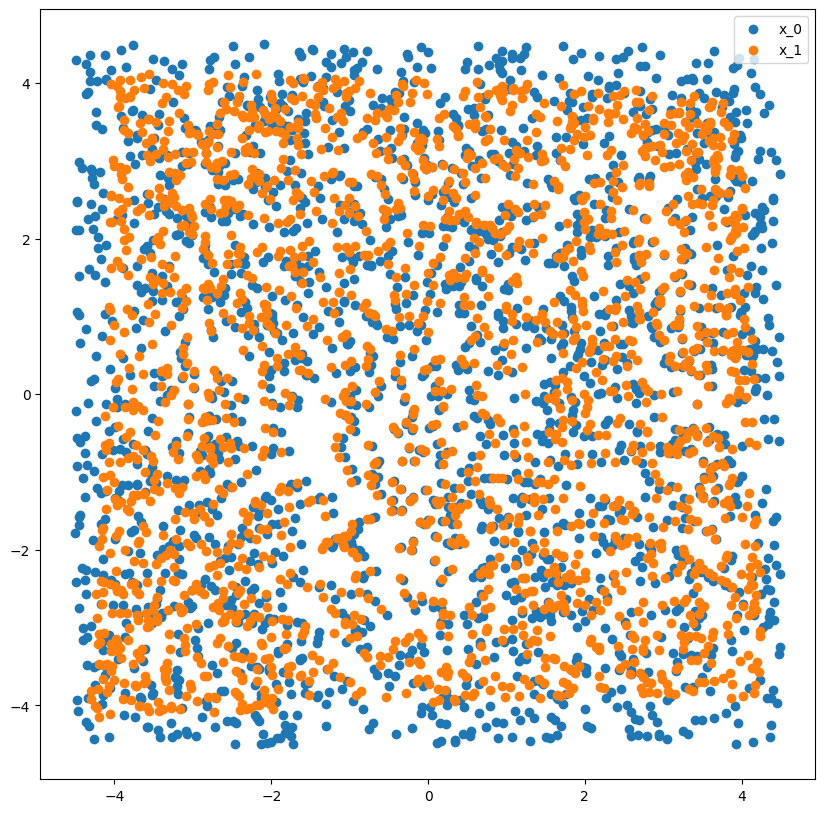

In [3]:
#plotting data
fig = plt.figure(figsize=(10,10))
plt.scatter(data_x0[:,0], data_x0[:,1], label="x_0")
plt.scatter(data_x1[:,0], data_x1[:,1], label="x_1")
plt.legend()
plt.show()

### Task 3.1

In [4]:
delta_t = 0.01
v_hat = estimate_vector(data_x0, data_x1,delta_t)
A_approximated = lstsq(data_x0, v_hat, cond=None)[0]

In [5]:
# Define linear approximation function
def linear_approximation(A, x0, delta_t):
    return x0 + delta_t * np.dot(A, x0.T)

In [6]:
# calculate mse
predicted_x1_all = np.array([linear_approximation(A_approximated, x0, delta_t) for x0 in data_x0])
mse_all = np.mean(np.square(data_x1 - predicted_x1_all))
print(f'Mean Squared Error: {mse_all}')

Mean Squared Error: 0.0186434856287006


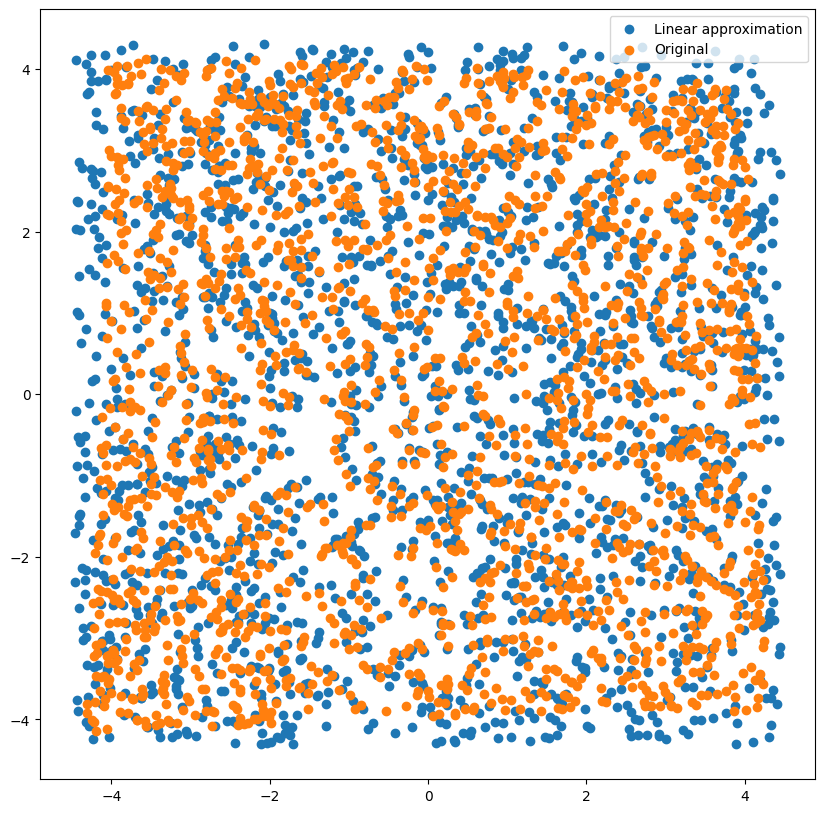

In [8]:
# plot approximated data
fig = plt.figure(figsize=(10,10))
plt.scatter(predicted_x1_all[:,0], predicted_x1_all[:,1], label="Linear approximation")
plt.scatter(data_x1[:,0], data_x1[:,1], label="Original")
plt.legend()
plt.show()

### Task 3.2

In [11]:
# def radial_basis_function(data, l, eps):
#     phi = []
#     np.random.seed(42)
#     x_l = np.random.choice(len(data), l, replace=False)

#     for i in range(l):
#         normalized_values = data - data[x_l[i]]
#         phi_l = np.exp(-np.sum(normalized_values ** 2, axis=1) / eps ** 2)
#         phi.append(phi_l)

#     return np.array(phi).T  # Transpose to have shape (number of data points, number of RBFs)

def radial_basis_function(data, l, eps):
    phi = []

    if len(data) == 1:
        # Handle the case of a single data point separately
        normalized_values = data - data[0]
        phi_l = np.exp(-np.sum(normalized_values ** 2, axis=1) / eps ** 2)
        return phi_l.reshape(-1, 1)  # Reshape to make it a column vector

    np.random.seed(42)
    x_l = np.random.choice(len(data), l)

    for i in range(l):
        normalized_values = data - data[x_l[i]]
        phi_l = np.exp(-np.sum(normalized_values ** 2, axis=1) / eps ** 2)
        phi.append(phi_l)

    return np.array(phi).T  # Transpose to have shape (number of data points, number of RBFs)


In [12]:
# Approximate the vector field using RBF
def rbf_approximation(coefficients):
    return np.dot(phi, coefficients)

In [16]:
# find best combination of l and eps that yields lowest mse
larray = [800, 900, 1000]
epsarray = [1.5, 2, 2.5]
mse_rbf_array = []
mse_rbf_least = 10
eps_least = 0
l_least = 0

for l in larray:
    for eps in epsarray:
        
        phi = radial_basis_function(data_x0, l, eps)
        
        # Perform linear regression to estimate coefficients
        coefficients = lstsq(phi, v_hat, cond=None)[0]
        
        # Evaluate RBF approximation for all data points
        rbf_approximated_v = np.array(rbf_approximation(coefficients))

        # Calculate Mean Squared Error
        mse_rbf = np.mean(np.square(v_hat - rbf_approximated_v))
        mse_rbf_array.append((l, eps, mse_rbf))

        # Update if the current combination yields lower MSE
        if mse_rbf < mse_rbf_least:
            mse_rbf_least = mse_rbf
            eps_least = eps
            l_least = l
        
print(f'Least mean Squared Error (RBF): {mse_rbf_least} reached for: l={l_least}, eps={eps_least}')

Least mean Squared Error (RBF): 4.070405513144254e-12 reached for: l=1000, eps=2


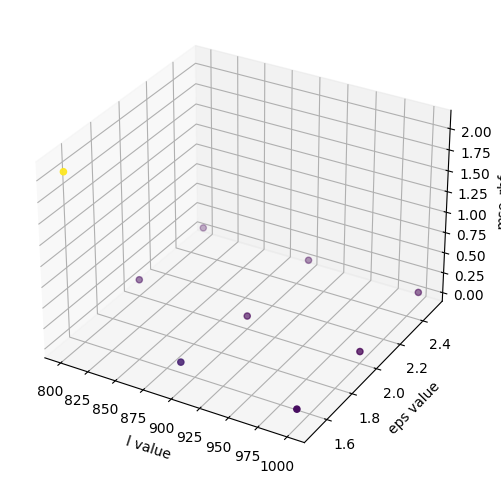

In [17]:
# comparison of l and eps values with their corresponding mse
l, eps, mse_rbf = zip(*mse_rbf_array)

# Convert to numpy arrays
l = np.array(l)
eps = np.array(eps)
mse_rbf = np.array(mse_rbf)

# Get unique values in l and eps
unique_l = np.unique(l)
unique_eps = np.unique(eps)

# Reshape to 2D arrays
l = l.reshape((len(unique_eps), len(unique_l)))
eps = eps.reshape((len(unique_eps), len(unique_l)))
mse_rbf = mse_rbf.reshape((len(unique_eps), len(unique_l)))

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the points with colors based on mse_rbf values
scatter = ax.scatter(l, eps, mse_rbf, c=mse_rbf, cmap='viridis', marker='o')

# Set labels
ax.set_xlabel('l value')
ax.set_ylabel('eps value')
ax.set_zlabel('mse_rbf')
#ax.set_title('3D Surface Plot')

# Show the plot
plt.show()


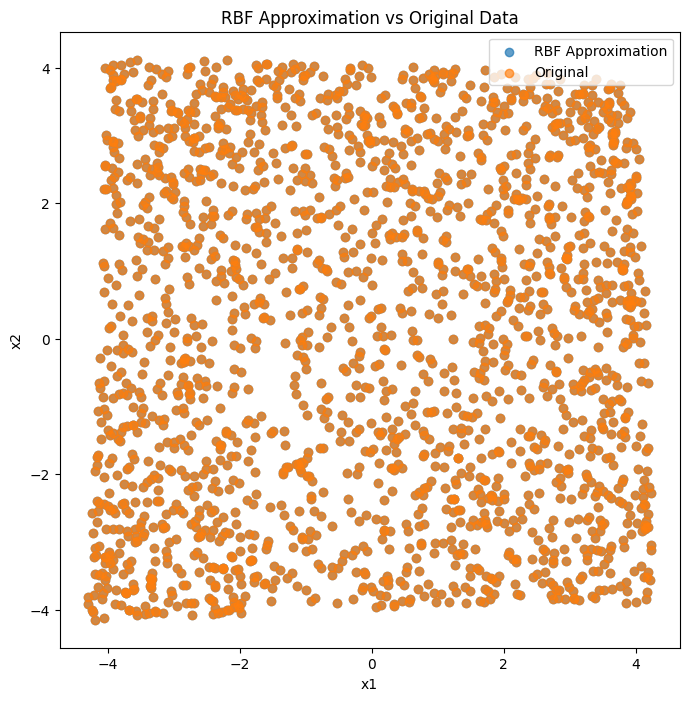

In [21]:
import matplotlib.pyplot as plt

# Recreate phi with the optimal l_least and eps_least
phi_optimal = radial_basis_function(data_x0, l_least, eps_least)

# Perform linear regression to estimate coefficients with the optimal phi
coefficients_optimal = lstsq(phi_optimal, v_hat, cond=None)[0]

# Evaluate RBF approximation for all data points in x1
rbf_approximated_v_x1 = np.dot(phi_optimal, coefficients_optimal)

def nonlinear_approximation(v_x1, x0, delta_t):
    return x0 + delta_t * v_x1

predicted_nonlinear = nonlinear_approximation(rbf_approximated_v_x1, data_x0, delta_t)

# Plot the RBF-approximated points
plt.figure(figsize=(8, 8))
plt.scatter(predicted_nonlinear[:, 0], predicted_nonlinear[:, 1], label='RBF Approximation', alpha=0.7)
plt.scatter(data_x1[:, 0], data_x1[:, 1], label='Original', alpha=0.7)
plt.title('RBF Approximation vs Original Data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()


### Task 3.3

In [38]:
t_final = 10  # Adjust as needed
delta_t = 0.01
num_steps = int((t_final) / delta_t) + 1

In [39]:
def simulate_system(vector_field, initial_points, t_final, delta_t, coefficients, phi):
    t_span = (0, t_final)
    t_eval = np.linspace(0, t_final, int((t_final) / delta_t) + 1)
    
    # Flatten all initial points
    initial_points_flattened = np.array([point.flatten() for point in initial_points])
    
    # Define a wrapper function for vector_field to handle flattened input
    def vector_field_wrapper(t, y, coefficients, phi):
        # Reshape y to match the original shape of initial_points
        y_reshaped = y.reshape((len(initial_points), 2))
        # Call the original vector_field function
        result = vector_field(t, y_reshaped.flatten(), coefficients, phi)
        # Return the result as a 1D array
        return result.flatten()
    
    # Solve the system for all initial points using the wrapper function
    sol = solve_ivp(vector_field_wrapper, y0=initial_points_flattened.flatten(), t_span=t_span, args=(coefficients, phi), t_eval=t_eval)
    
    # Reshape the solution to match the expected format
    solution = sol.y.reshape((len(initial_points), 2, len(t_eval)))

    return solution

def rbf_approximation_sim(t, y, coefficients, phi):
    # Assuming y is not used, modify as needed
    return phi @ coefficients

In [40]:
initial_points = data_x0

# Simulate the system using the RBF model
solution_rbf = simulate_system(rbf_approximation_sim, initial_points, t_final, delta_t, coefficients, phi)


ValueError: cannot reshape array of size 2 into shape (2000,2)

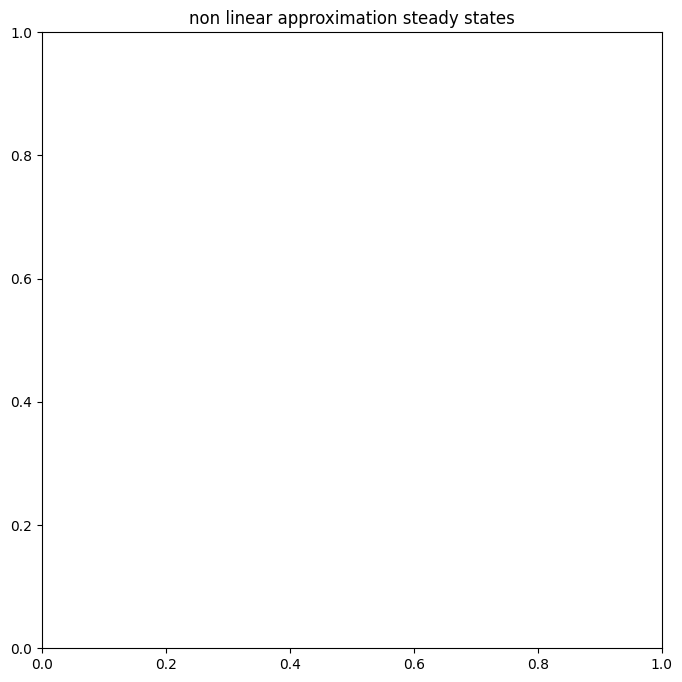

In [29]:
# see steady states, copied and adapted, doesn't work :(

from scipy.spatial.distance import cdist

# Define a wrapper function for vector_field to handle flattened input
def vector_field_wrapper(t, y, coefficients, phi):
    # Reshape y to match the original shape of initial_points
    y_reshaped = y.reshape((len(initial_points), 2))
    # Call the original vector_field function
    result = vector_field(t, y_reshaped.flatten(), coefficients, phi)
    # Return the result as a 1D array
    return result.flatten()

def rbf_approx(t, y, centers, eps, C):
    """
    function to return vector field of a single point (rbf)
    :param t: time (for solve_ivp)
    :param y: single point
    :param centers: all centers
    :param eps: radius of gaussians
    :param C: coefficient matrix, found with least squares
    :return: derivative for point y
    """
    y = y.reshape(1, y.shape[-1])
    phi = np.exp(-cdist(y, centers) ** 2 / eps ** 2)
    return phi @ C

end_time = 50
centers = data_x0[np.random.choice(range(data_x0.shape[0]), replace=False, size=l_least)]
plt.title("non linear approximation steady states")
for i in range(len(data_x0)):
    #coefficients = coefficients.squeeze()
    #sol = solve_ivp(rbf_approx, [0, end_time],  data_x0[i], args=[centers, eps, coefficients])
    t_eval = np.linspace(0, 10, int((10) / 0.01) + 1)
    sol = solve_ivp(vector_field_wrapper, y0=data_x0[i], t_span=(0,10), args=(coefficients, phi), t_eval=t_eval)
    
    # Reshape the solution to match the expected format
    solution = sol.y.reshape((len(initial_points), 2, len(t_eval)))
    plt.scatter(sol.y[0,-1], sol.y[1,-1])
plt.xlim(-4.5, 4.5)
plt.ylim(-4.5, 4.5)
plt.show()

